In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

from scipy.stats import f_oneway

In [2]:
df = pd.read_csv('./booking.csv')

df.columns = df.columns.str.replace(' ', '')

# drop unimportant columns
df.drop(labels = ['Booking_ID', 'dateofreservation'], axis = 1, inplace = True)
df.head()

,numberofadults,numberofchildren,numberofweekendnights,numberofweeknights,typeofmeal,carparkingspace,roomtype,leadtime,marketsegmenttype,repeated,P-C,P-not-C,averageprice,specialrequests,bookingstatus
0,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,Not_Canceled
1,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,Not_Canceled
2,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,Canceled
3,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,Canceled
4,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,Canceled


In [3]:
# from a quick groupby, we can get a sense of which variables vary significantly based on booking status
group = df.groupby('bookingstatus').mean(numeric_only = True)
group

,numberofadults,numberofchildren,numberofweekendnights,numberofweeknights,carparkingspace,leadtime,repeated,P-C,P-not-C,averageprice,specialrequests
bookingstatus,,,,,,,,,,,
Canceled,1.909328,0.124401,0.887375,2.392211,0.009589,139.219615,0.001346,0.005551,0.002187,110.580263,0.334679
Not_Canceled,1.813412,0.096081,0.773323,2.113174,0.041400,58.933678,0.037465,0.032013,0.227045,99.932994,0.758649


# Numeric Variable Exploration

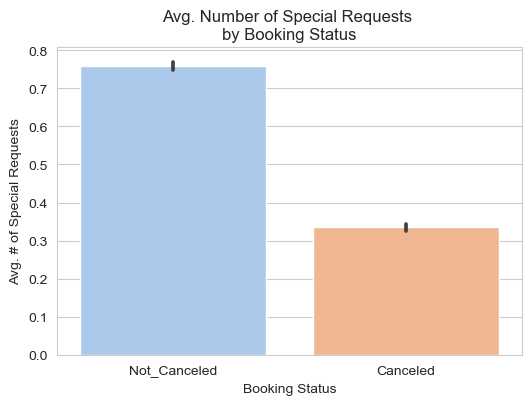

In [4]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'bookingstatus', y = 'specialrequests')

plt.title("Avg. Number of Special Requests \nby Booking Status")
plt.xlabel("Booking Status")
plt.ylabel("Avg. # of Special Requests")
plt.show()

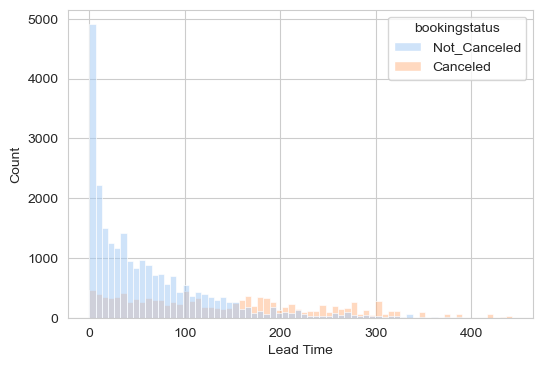

In [5]:
plt.figure(figsize = (6,4))
sns.histplot(data = df, x = 'leadtime', hue = 'bookingstatus')
plt.xlabel("Lead Time")
plt.show()

<p style="color: blue; font-size: 18px; padding-left: 50px; padding-bottom: 30px">From the graph above, it's clear that bookings with smaller lead times are not typically cancelled.</p>

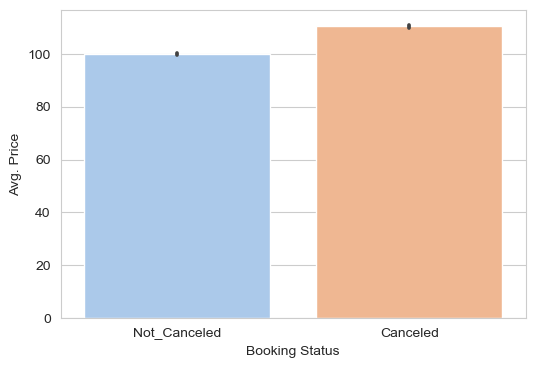

In [6]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'bookingstatus', y = 'averageprice')

plt.ylabel("Avg. Price")
plt.xlabel("Booking Status")
plt.show()

<p style="color: blue; font-size: 18px; padding-left: 50px; padding-bottom: 30px">Customers who pay less are less likely to cancel their reservation.</p>

# Categorical Variable Exploration

In [7]:
cat_df = df[['typeofmeal', 'roomtype', 'marketsegmenttype', 'bookingstatus']].copy()

# let's turn booking status into 0s and 1s so that we can compare categorical variables
cat_df.bookingstatus.replace({'Not_Canceled': 0, 'Canceled': 1}, inplace = True)
cat_df.head()

,typeofmeal,roomtype,marketsegmenttype,bookingstatus
0,Meal Plan 1,Room_Type 1,Offline,0
1,Not Selected,Room_Type 1,Online,0
2,Meal Plan 1,Room_Type 1,Online,1
3,Meal Plan 1,Room_Type 1,Online,1
4,Not Selected,Room_Type 1,Online,1


In [8]:
cat_df.groupby('roomtype').aggregate({'bookingstatus': ['mean', 'count']})

bookingstatus       
                     mean  count
roomtype                        
Room_Type 1      0.322553  28138
Room_Type 2      0.329480    692
Room_Type 3      0.285714      7
Room_Type 4      0.341475   6059
Room_Type 5      0.271698    265
Room_Type 6      0.420290    966
Room_Type 7      0.227848    158

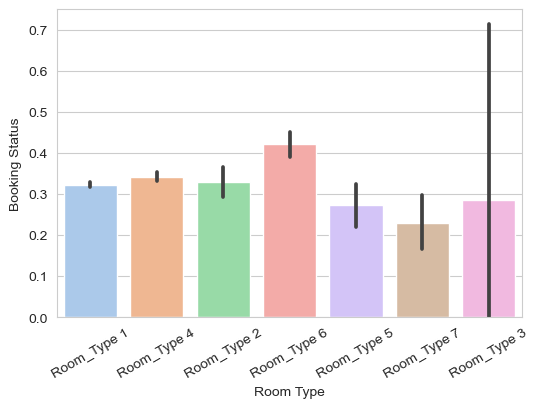

In [9]:
plt.figure(figsize = (6,4))
sns.barplot(data = cat_df, x = 'roomtype', y = 'bookingstatus')

plt.xlabel("Room Type")
plt.ylabel("Booking Status")
plt.xticks(rotation=30)
plt.show()

In [10]:
# conduct one way anova test on room type
f_oneway(cat_df[cat_df.roomtype == 'Room_Type 1'].bookingstatus, 
         cat_df[cat_df.roomtype == 'Room_Type 2'].bookingstatus, 
         cat_df[cat_df.roomtype == 'Room_Type 4'].bookingstatus,
         cat_df[cat_df.roomtype == 'Room_Type 5'].bookingstatus,
         cat_df[cat_df.roomtype == 'Room_Type 6'].bookingstatus,
         cat_df[cat_df.roomtype == 'Room_Type 7'].bookingstatus)

F_onewayResult(statistic=11.441558029763058, pvalue=4.675845443453301e-11)

In [11]:
cat_df.groupby('typeofmeal').aggregate({'bookingstatus': ['mean', 'count']})

bookingstatus       
                      mean  count
typeofmeal                       
Meal Plan 1       0.311795  27842
Meal Plan 2       0.455838   3306
Meal Plan 3       0.200000      5
Not Selected      0.331255   5132

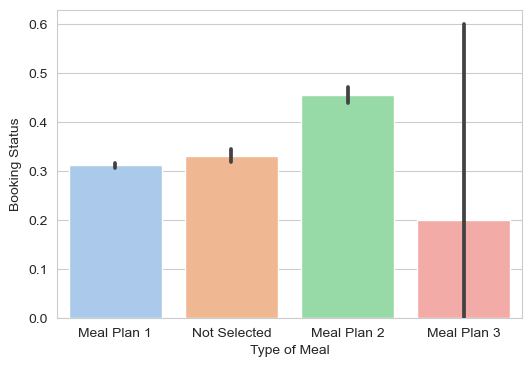

In [12]:
plt.figure(figsize = (6,4))
sns.barplot(data = cat_df, x = 'typeofmeal', y = 'bookingstatus')

plt.xlabel("Type of Meal")
plt.ylabel("Booking Status")
plt.show()

In [13]:
# conduct one way anova test on meal plans
f_oneway(cat_df[cat_df.typeofmeal == 'Meal Plan 1'].bookingstatus, 
         cat_df[cat_df.typeofmeal == 'Meal Plan 2'].bookingstatus, 
         cat_df[cat_df.typeofmeal == 'Not Selected'].bookingstatus)

F_onewayResult(statistic=140.39757772107458, pvalue=1.823368344064935e-61)

In [14]:
cat_df.groupby('marketsegmenttype').aggregate({'bookingstatus': ['mean', 'count']})

bookingstatus       
                           mean  count
marketsegmenttype                     
Aviation               0.296000    125
Complementary          0.000000    391
Corporate              0.109073   2017
Offline                0.299497  10531
Online                 0.365101  23221

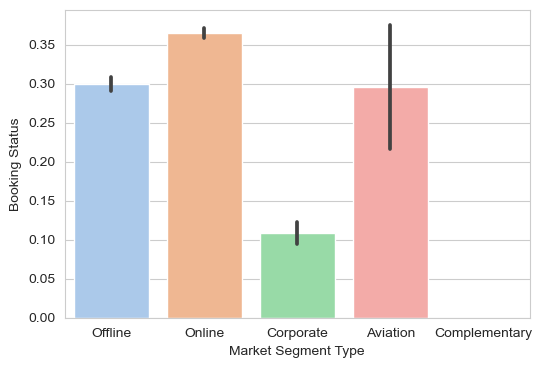

In [15]:
plt.figure(figsize = (6,4))
sns.barplot(data = cat_df, x = 'marketsegmenttype', y = 'bookingstatus')

plt.xlabel("Market Segment Type")
plt.ylabel("Booking Status")
# plt.xticks(rotation=30)
plt.show()

In [16]:
# conduct one way anova test on market segment type
f_oneway(cat_df[cat_df.marketsegmenttype == 'Offline'].bookingstatus, 
         cat_df[cat_df.marketsegmenttype == 'Online'].bookingstatus, 
         cat_df[cat_df.marketsegmenttype == 'Corporate'].bookingstatus,
         cat_df[cat_df.marketsegmenttype == 'Aviation'].bookingstatus,
         cat_df[cat_df.marketsegmenttype == 'Complementary'].bookingstatus)

F_onewayResult(statistic=208.21033203052562, pvalue=6.3987476897181625e-177)

# Significance Testing

Let's see if the variation of numeric variables is statistically significantly different based on our independent variable.

In [17]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

In [18]:
def generate_diffs_and_graph(col, len_a, df, pos_col, neg_col):
    # generated permuted differences
    actual_diff = group.loc[pos_col][col] - group.loc[neg_col][col]
    diffs = [perm_fun(df, col, len_a) for _ in range(1000)]
    
    # plot permuted differences and actual difference
    plt.figure(figsize = (5,4))
    sns.histplot(diffs)
    plt.axvline(x = actual_diff, color = 'red')
    plt.title(f"Perm Test (statistical significance) for {col}")
    plt.show()

    # calculate and print p-val for statistical significance test
    p_val = [np.abs(diff) > np.abs(actual_diff) for diff in diffs]
    p_val = np.array(p_val).mean()
    print("p-val:", p_val)
    
    return p_val

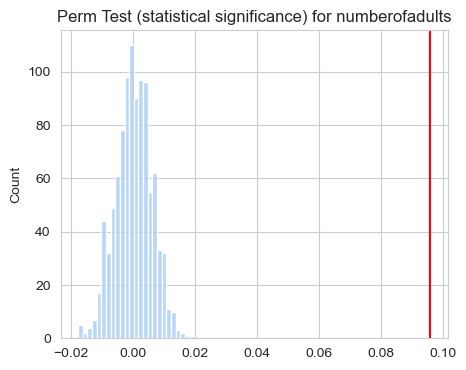

p-val: 0.0


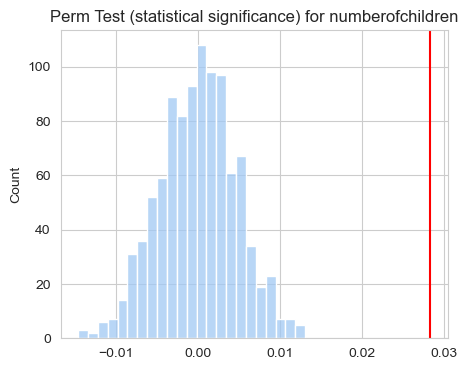

p-val: 0.0


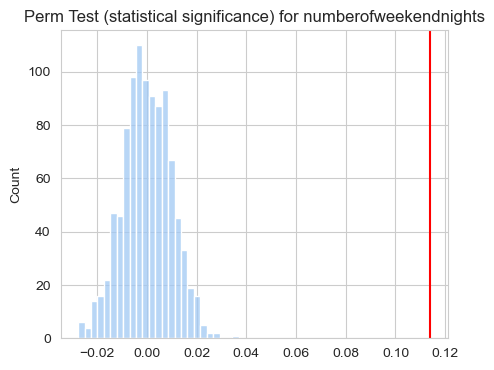

p-val: 0.0


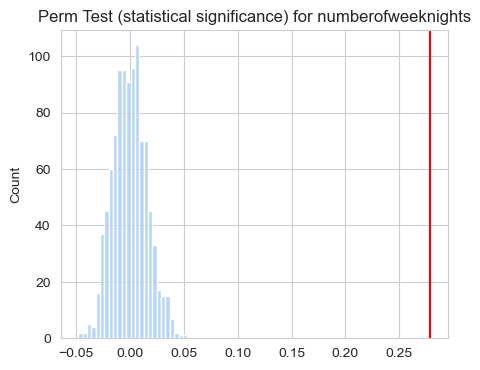

p-val: 0.0


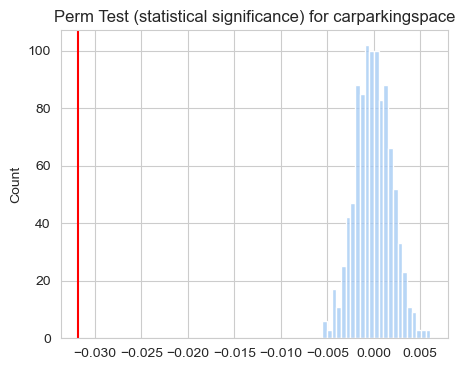

p-val: 0.0


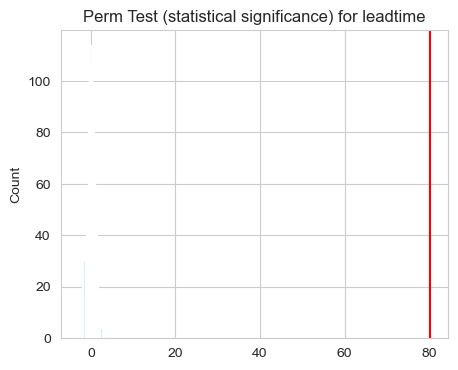

p-val: 0.0


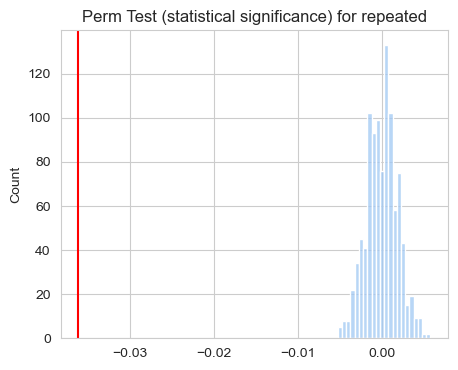

p-val: 0.0


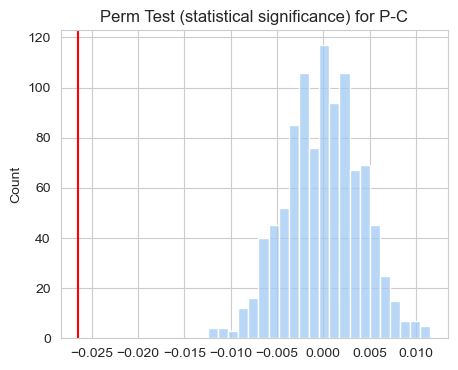

p-val: 0.0


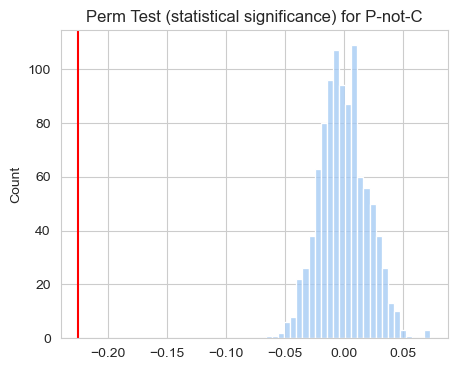

p-val: 0.0


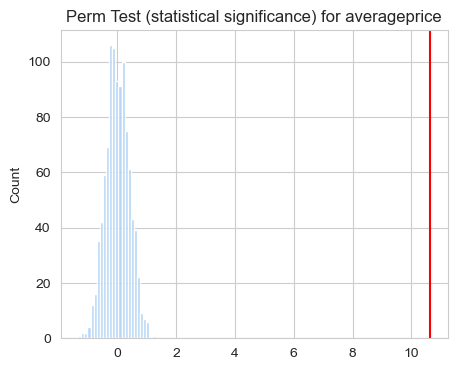

p-val: 0.0


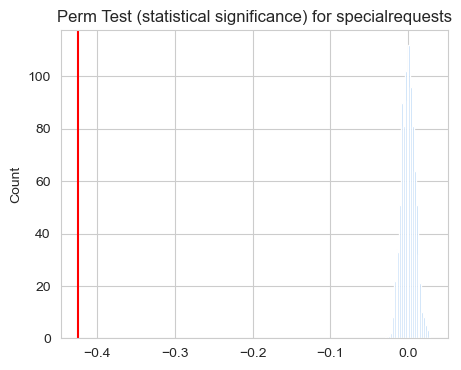

p-val: 0.0


In [19]:
significant_vars = []
len_a = df.bookingstatus.value_counts().loc['Canceled']

for col in group.columns:
    p_val = generate_diffs_and_graph(col, len_a, df, 'Canceled', 'Not_Canceled')
    if (p_val <= .05):
        significant_vars.append(col)

In [20]:
significant_vars

['numberofadults',
 'numberofchildren',
 'numberofweekendnights',
 'numberofweeknights',
 'carparkingspace',
 'leadtime',
 'repeated',
 'P-C',
 'P-not-C',
 'averageprice',
 'specialrequests']

# Pipeline

## Cat Pipeline

In [21]:
cat_vars = ['marketsegmenttype', 'typeofmeal', 'roomtype']

booking_cat = df[cat_vars]

cat_pipeline = Pipeline([
    ('categorical encoder', OneHotEncoder()) # get one hot values
])

booking_cat_tr = cat_pipeline.fit_transform(booking_cat)
booking_cat_tr = booking_cat_tr.toarray()
booking_cat_tr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Numeric Pipeline

In [22]:
numeric = df[significant_vars]

num_pipeline = Pipeline([
    ('scale', StandardScaler())
])
numeric_tr = num_pipeline.fit_transform(numeric)
numeric_tr

array([[-1.62843143,  2.2216095 ,  1.36611105, ..., -0.08744431,
        -0.43953834, -0.78821183],
       [-1.62843143, -0.26163555,  0.21744953, ..., -0.08744431,
         0.09286796,  0.48364596],
       [ 0.29907255,  2.2216095 ,  0.21744953, ..., -0.08744431,
        -1.52259184, -0.78821183],
       ...,
       [ 0.29907255, -0.26163555,  0.21744953, ..., -0.08744431,
         0.06237146,  0.48364596],
       [ 2.22657653, -0.26163555, -0.931212  , ..., -0.08744431,
        -0.18587581,  0.48364596],
       [ 0.29907255, -0.26163555, -0.931212  , ..., -0.08744431,
         0.85556564,  3.02736155]])

In [23]:
num_columns = significant_vars # list of num column names
cat_columns = cat_vars # list of cat column names

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('cat', cat_pipeline, cat_columns)
])

data_prepared = full_pipeline.fit_transform(df)
data_prepared

array([[-1.62843143,  2.2216095 ,  1.36611105, ...,  0.        ,
         0.        ,  0.        ],
       [-1.62843143, -0.26163555,  0.21744953, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29907255,  2.2216095 ,  0.21744953, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.29907255, -0.26163555,  0.21744953, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.22657653, -0.26163555, -0.931212  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29907255, -0.26163555, -0.931212  , ...,  0.        ,
         0.        ,  0.        ]])

# Machine Learning Model

In [24]:
X = data_prepared
y = df.bookingstatus.replace({'Canceled': 1, 'Not_Canceled': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 21)

xgb = XGBClassifier(n_estimators = 100, max_depth = 10, gamma = 10, learning_rate = .1)

In [25]:
xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [26]:
predictions = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))

Accuracy: 0.8816315281796886
Precision: 0.8690019193857965
Recall: 0.7555277430120985


# Hypertune Parameters using Cross-Validation

In [27]:
# perform grid search to tune hyperparameters
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 6],
    "gamma": [1, 5],
    "learning_rate": [.01, .05]
}

xgb = XGBClassifier()

grid = GridSearchCV(xgb, param_grid = params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...e,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_chil

In [28]:
grid.best_params_

{'gamma': 1, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

In [29]:
# retrain model with the hypertuned parameters
tuned_model = XGBClassifier(n_estimators = grid.best_params_["max_depth"], max_depth = grid.best_params_["n_estimators"],
                      gamma = grid.best_params_["gamma"], learning_rate = grid.best_params_["learning_rate"])
tuned_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=200, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=6, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [31]:
predictions = tuned_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))

Accuracy: 0.8768085985944605
Precision: 0.8439359267734554
Recall: 0.7692949520233625
